**Upload and Extract Dataset**

In [ ]:
!rm -rf emotion_recognition_dataset

In [ ]:
from zipfile import ZipFile

# Unzip the dataset
with ZipFile("emotion_recognition_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("emotion_recognition_dataset")


**Import Necessary Libraries**

In [ ]:
!pip install tensorflow
!pip install keras

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold


**Load Data Using ImageDataGenerator**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Path to dataset directories
train_dir = 'emotion_recognition_dataset/emotion_recognition_dataset/train'
test_dir = 'emotion_recognition_dataset/emotion_recognition_dataset/test'

# Load the train data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    color_mode="grayscale",
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical'
)

# Load the test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    color_mode="grayscale",
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)


Found 22894 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


**Handling Class Imbalance**

In [ ]:
# Calculate class weights for handling imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)


{0: 0.955110554860242, 1: 0.9970385854890689, 2: 0.921658615136876, 3: 0.9620944696587662, 4: 1.005445761967501, 5: 1.203300746347104}


**Build the Model**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

def create_model():
    model = Sequential([
        Conv2D(64, (3, 3), input_shape=(48, 48, 1)),
        BatchNormalization(),  # Before activation
        tf.keras.layers.ReLU(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3)),
        BatchNormalization(),
        tf.keras.layers.ReLU(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(256, (3, 3)),
        BatchNormalization(),
        tf.keras.layers.ReLU(),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(256),
        BatchNormalization(),
        tf.keras.layers.ReLU(),
        Dropout(0.5),
        Dense(6, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

**Train the Model with cross-validation**

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Extract data from train_generator
X, y = [], []
for batch_x, batch_y in train_generator:
    X.extend(batch_x)
    y.extend(np.argmax(batch_y, axis=1))
    if len(X) >= train_generator.samples:
        break

X = np.array(X)
y = np.array(y)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

# Data augmentation for training data
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)


In [ ]:
# Train the model
model = create_model()
history = model.fit(
    datagen.flow(X_train, tf.keras.utils.to_categorical(y_train, num_classes=train_generator.num_classes), batch_size=64),
    validation_data=(X_val, tf.keras.utils.to_categorical(y_val, num_classes=train_generator.num_classes)),
    epochs=30,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model
scores = model.evaluate(X_val, tf.keras.utils.to_categorical(y_val), verbose=0)
print(f'Validation Accuracy: {scores[1]}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


287/287 ━━━━━━━━━━━━━━━━━━━━ 287s 982ms/step - accuracy: 0.2411 - loss: 2.0339 - val_accuracy: 0.1743 - val_loss: 1.9090 - learning_rate: 0.0010
Epoch 2/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 294s 1s/step - accuracy: 0.3283 - loss: 1.6692 - val_accuracy: 0.3909 - val_loss: 1.5204 - learning_rate: 0.0010
Epoch 3/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 284s 989ms/step - accuracy: 0.4062 - loss: 1.4694 - val_accuracy: 0.4007 - val_loss: 1.4860 - learning_rate: 0.0010
Epoch 4/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 291s 1s/step - accuracy: 0.4369 - loss: 1.3921 - val_accuracy: 0.4208 - val_loss: 1.4501 - learning_rate: 0.0010
Epoch 5/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 280s 975ms/step - accuracy: 0.4561 - loss: 1.3581 - val_accuracy: 0.4298 - val_loss: 1.4169 - learning_rate: 0.0010
Epoch 6/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 318s 962ms/step - accuracy: 0.4793 - loss: 1.3042 - val_accuracy: 0.4979 - val_loss: 1.2789 - learning_rate: 0.0010
Epoch 7/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 331s 993ms/step - accuracy: 0.4896 - loss

**Visualizing Accuracy and Loss**

**Make Predictions and Generate Confusion Matrix**

111/111 ━━━━━━━━━━━━━━━━━━━━ 22s 199ms/step
Classification Report:
              precision    recall  f1-score   support

       angry       0.49      0.61      0.55       958
        fear       0.45      0.37      0.41      1024
       happy       0.89      0.76      0.82      1774
     neutral       0.50      0.68      0.57      1233
         sad       0.52      0.42      0.47      1247
    surprise       0.74      0.72      0.73       831

    accuracy                           0.61      7067
   macro avg       0.60      0.60      0.59      7067
weighted avg       0.62      0.61      0.61      7067

Confusion Matrix:
[[ 588   91   19  148   88   24]
 [ 165  382   20  178  179  100]
 [ 115   66 1345  156   44   48]
 [  90   67   57  838  159   22]
 [ 191  140   40  328  526   22]
 [  45  100   23   44   17  602]]


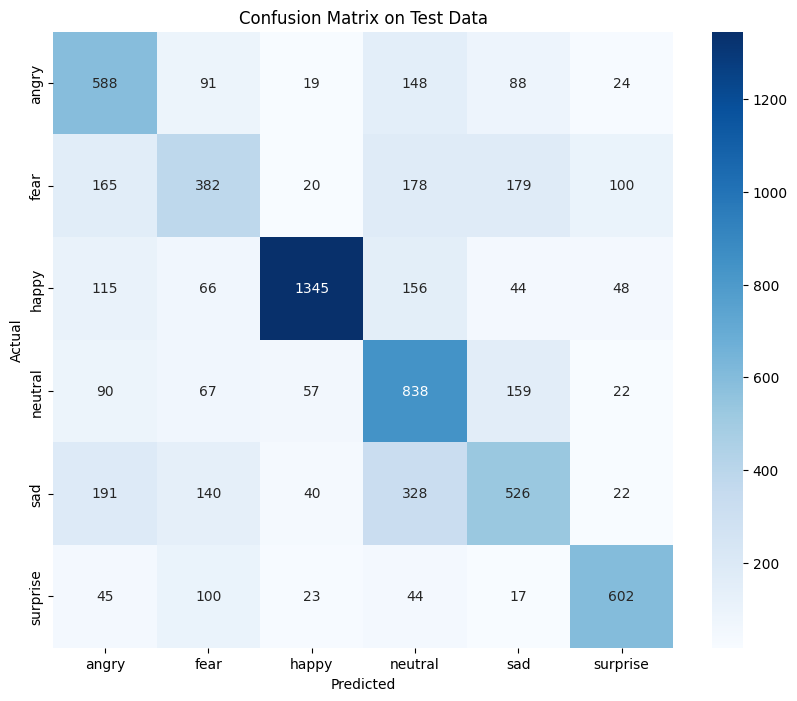

In [ ]:
# Predict on test set
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Classification report
class_labels = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix on Test Data')
plt.show()


**Save the Model**

In [ ]:
# Save the model
model.save('emotion_recognition_model.keras')
print("Model saved as emotion_recognition_model.keras")


Model saved as emotion_recognition_model.keras


In [ ]:
import json

# Define emotion map
emotion_map = {0: 'angry', 1: 'fear', 2: 'Happy', 3: 'neutral', 4:'sad', 5:'suprise'}

# Save to JSON file
with open('emotion_labels.json', 'w') as json_file:
    json.dump(emotion_map, json_file)


---  

---  

**Test on real world images**

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import json
import matplotlib.pyplot as plt


In [ ]:
# Load the trained emotion recognition model
emotion_recognition_model = load_model('emotion_recognition_model.keras')

# Load the emotion labels
with open('emotion_labels.json', 'r') as json_file:
    emotion_map = json.load(json_file)

# Load the Haar Cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to detect faces and predict emotions
def detect_and_predict_emotion(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image at {image_path}")
        return None  # Return None to indicate an error

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    if len(faces) == 0:
        print(f"Warning: No faces detected in {image_path}")
        return img

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y + h, x:x + w]
        roi_gray = cv2.resize(roi_gray, (48, 48))
        roi_gray = roi_gray / 255.0  # Normalize pixel values
        roi_gray = np.expand_dims(roi_gray, axis=0)  # Add batch dimension
        roi_gray = np.expand_dims(roi_gray, axis=-1)  # Add channel dimension
        emotion_prediction = emotion_recognition_model.predict(roi_gray)
        predicted_emotion_index = np.argmax(emotion_prediction)

        # Handle cases where the predicted index is not in emotion_map
        try:
          predicted_emotion = emotion_map[str(predicted_emotion_index)]
        except KeyError:
          print(f"Warning: Predicted emotion index {predicted_emotion_index} not found in emotion map.")
          predicted_emotion = "Unknown"


        # Calculate text size
        (text_width, text_height), _ = cv2.getTextSize(predicted_emotion, cv2.FONT_HERSHEY_SIMPLEX, 0.9, 2)

        # Adjust text position if it goes out of bounds
        text_x = max(x, 0) # Ensure text_x is not negative (out of left bound)
        text_y = max(y - 10, text_height + 5) # Ensure text_y is below the top bound

        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(img, predicted_emotion, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    return img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


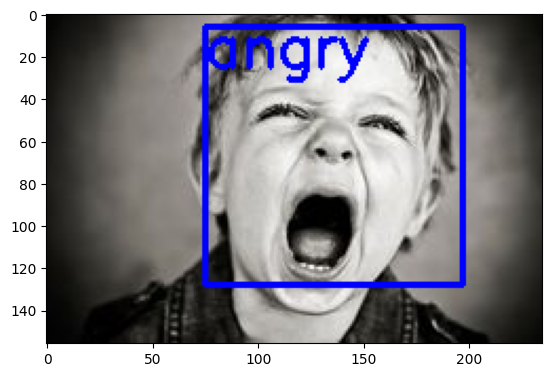

In [ ]:
# Example usage:
image_path = "angry.jpg"
result_image = detect_and_predict_emotion(image_path)
cv2.imwrite("result_image.jpg", result_image) # Save the image with detected faces and emotions
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)) # Display using matplotlib
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


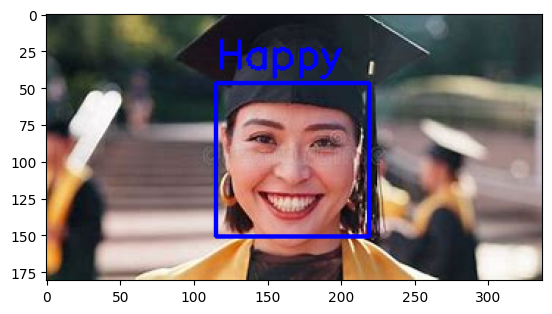

In [ ]:
# Example usage:
image_path = "happpy.jpg"
result_image = detect_and_predict_emotion(image_path)
cv2.imwrite("result_image.jpg", result_image) # Save the image with detected faces and emotions
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)) # Display using matplotlib
plt.show()

---  